## Spark OCR Morphology operations example

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [6]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-1.4.0rc1.tar.gz

## Initialization of spark session

In [2]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

SparkConf Configured, Starting to listen on port: 58200
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Imports

In [3]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image
from sparkocr.metrics import score

## Read image

In [283]:
import pkg_resources
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_raw = spark.read.format("binaryFile").load(imagePath)
image_df = BinaryToImage().transform(image_raw)
image_df = ImageScaler().setInputCol("image").setOutputCol("scaled_image").setScaleFactor(2.0).transform(image_df)
image_df.show()

+--------------------+--------------------+-------------------+------+-------+--------------------+---------+
|               image|                path|   modificationTime|length|pagenum|        scaled_image|exception|
+--------------------+--------------------+-------------------+------+-------+--------------------+---------+
|[file:/Users/nmel...|file:/Users/nmeln...|2020-06-15 20:06:17|111835|      0|[file:/Users/nmel...|     null|
+--------------------+--------------------+-------------------+------+-------+--------------------+---------+



Image:
        origin: file:/Users/nmelnik/Downloads/check.jpg 
        width: 1164
        height: 1488
        mode: 10


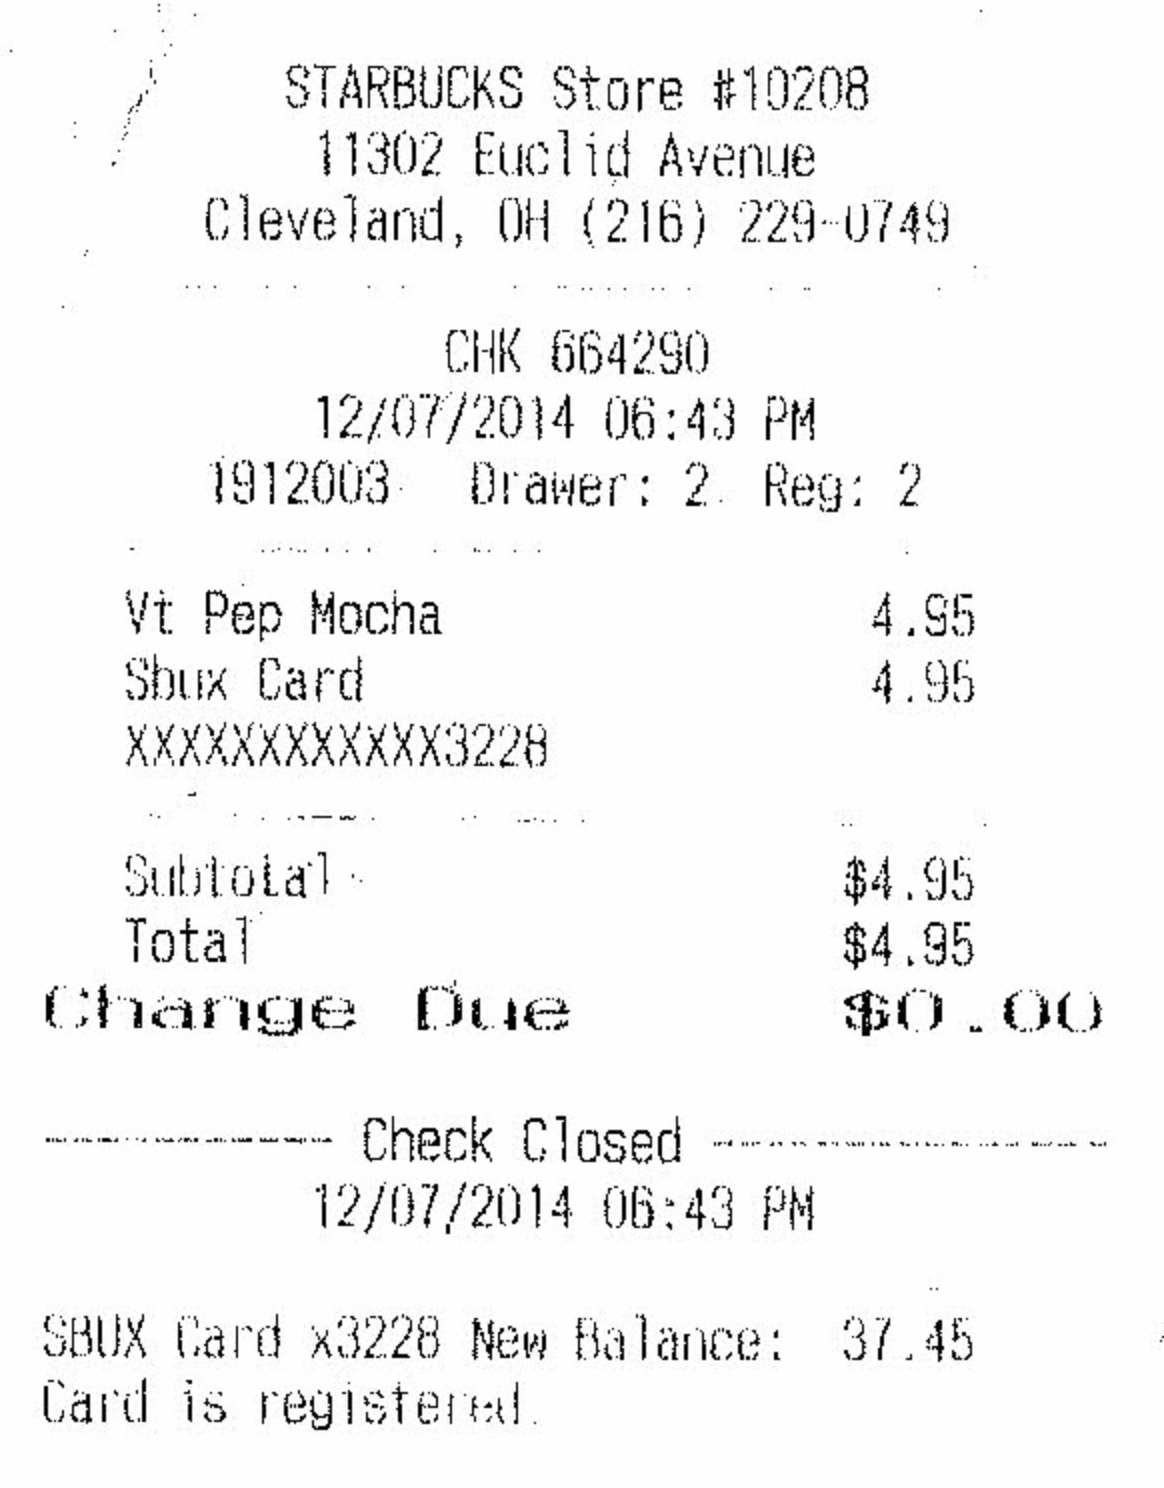

In [284]:
display_image(image_df.select("scaled_image").collect()[0].scaled_image)

## Image Adaptive Thresholding

Image:
        origin: file:/Users/nmelnik/Downloads/check.jpg 
        width: 1164
        height: 1488
        mode: 10


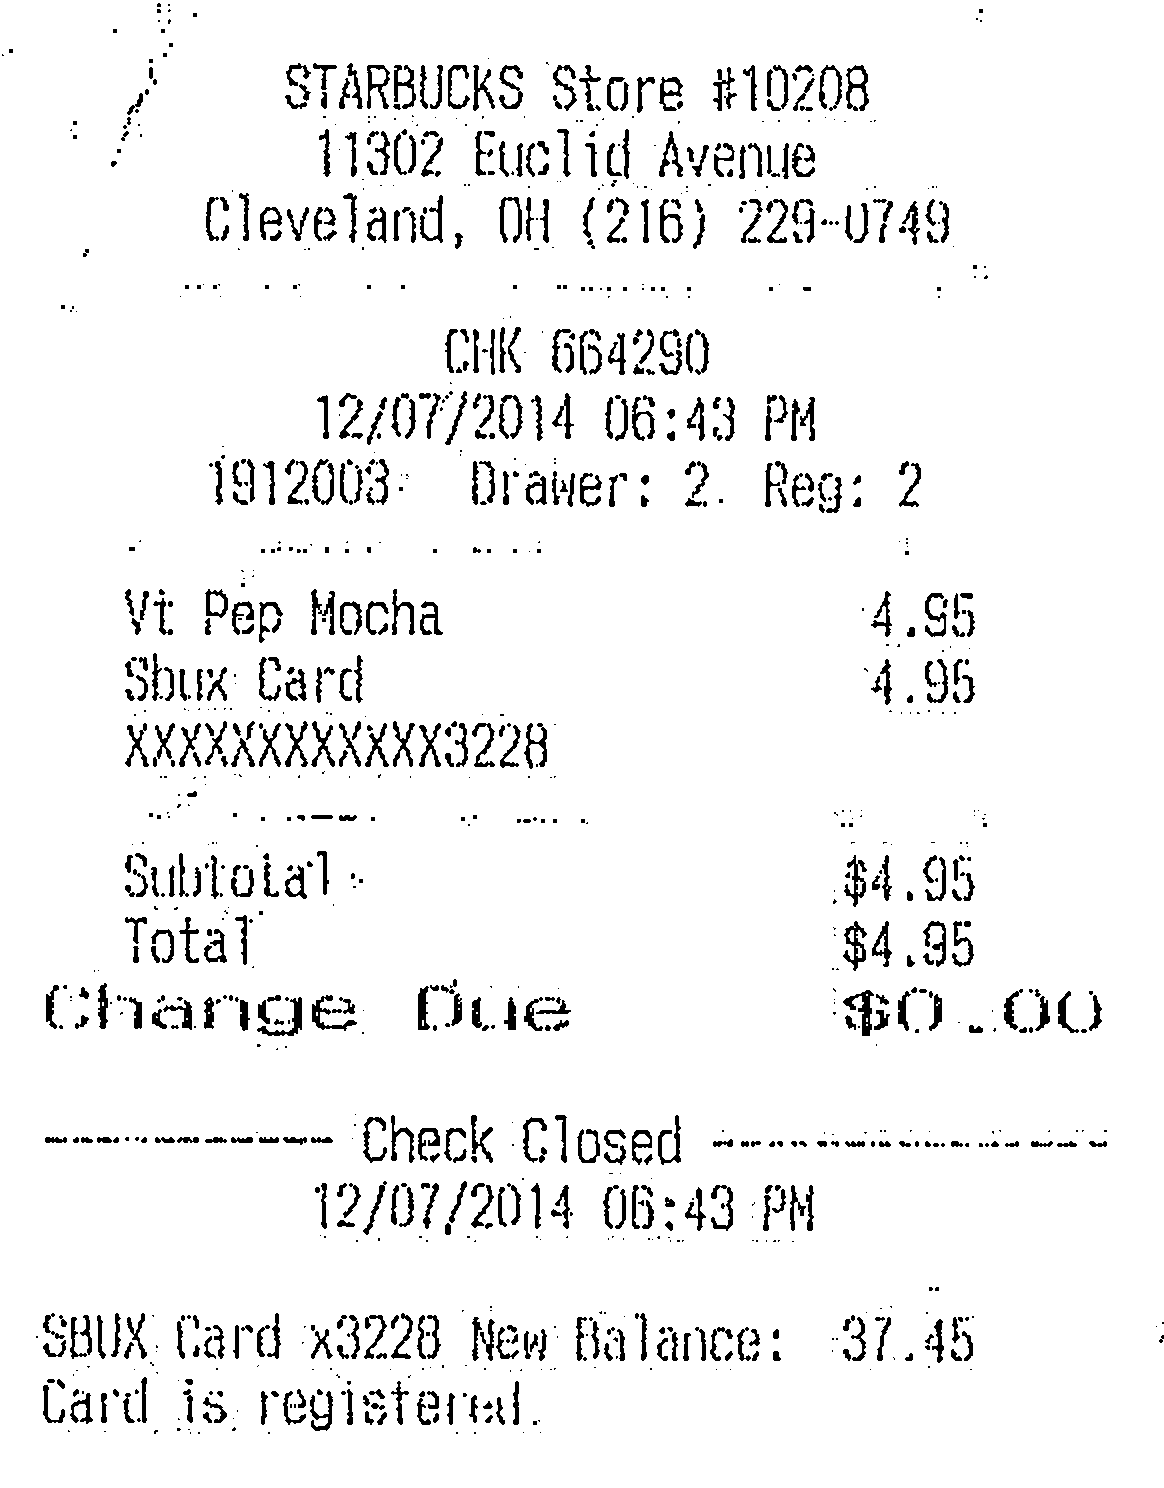

In [285]:
binirized_image = ImageAdaptiveThresholding() \
.setBlockSize(31) \
.setOffset(5) \
.setInputCol("scaled_image") \
.setOutputCol("binarized_image") \
.transform(image_df)

display_image(binirized_image.select("binarized_image").collect()[0].binarized_image)

## Closing/Opening

Image:
        origin: file:/Users/nmelnik/Downloads/check.jpg 
        width: 1164
        height: 1488
        mode: 10


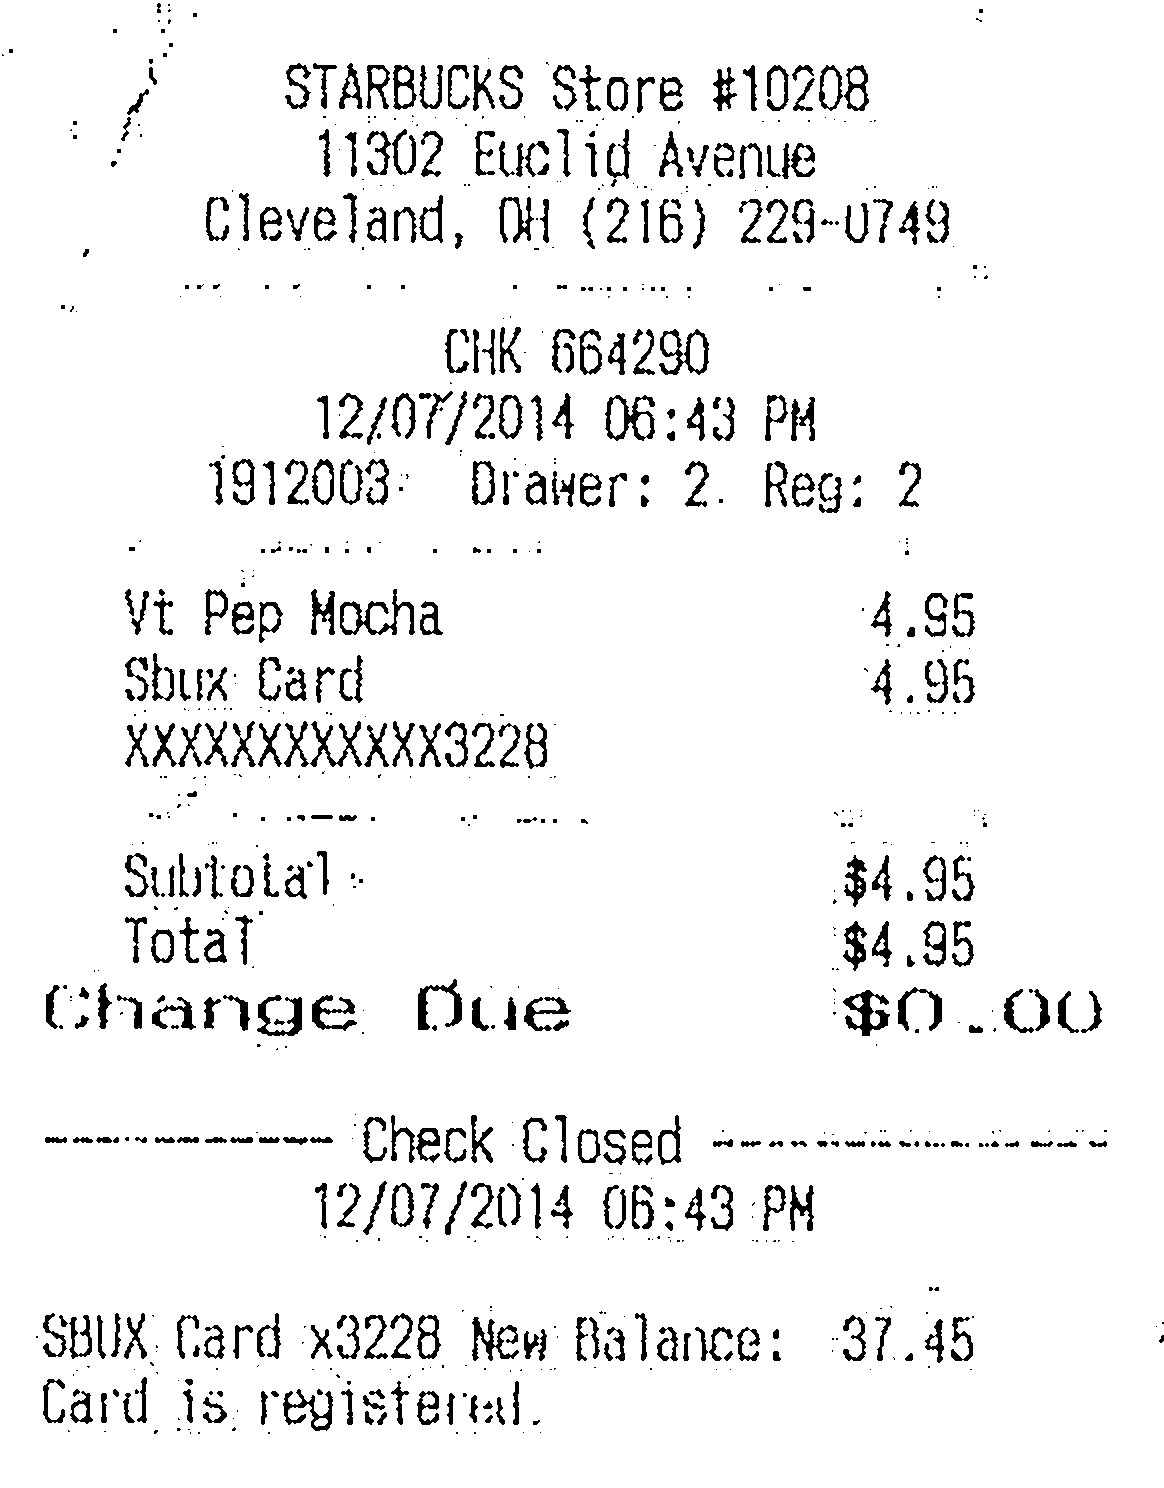

In [302]:
closing_image = ImageMorphologyOperation() \
.setKernelShape(KernelShape.DISK) \
.setKernelSize(2) \
.setOperation("closing") \
.setInputCol("binarized_image") \
.setOutputCol("closing_image") \
.transform(binirized_image)

display_image(closing_image.select("closing_image").collect()[0].closing_image)

## Erosion/Dilation

Image:
        origin: file:/Users/nmelnik/Downloads/check.jpg 
        width: 1164
        height: 1488
        mode: 10


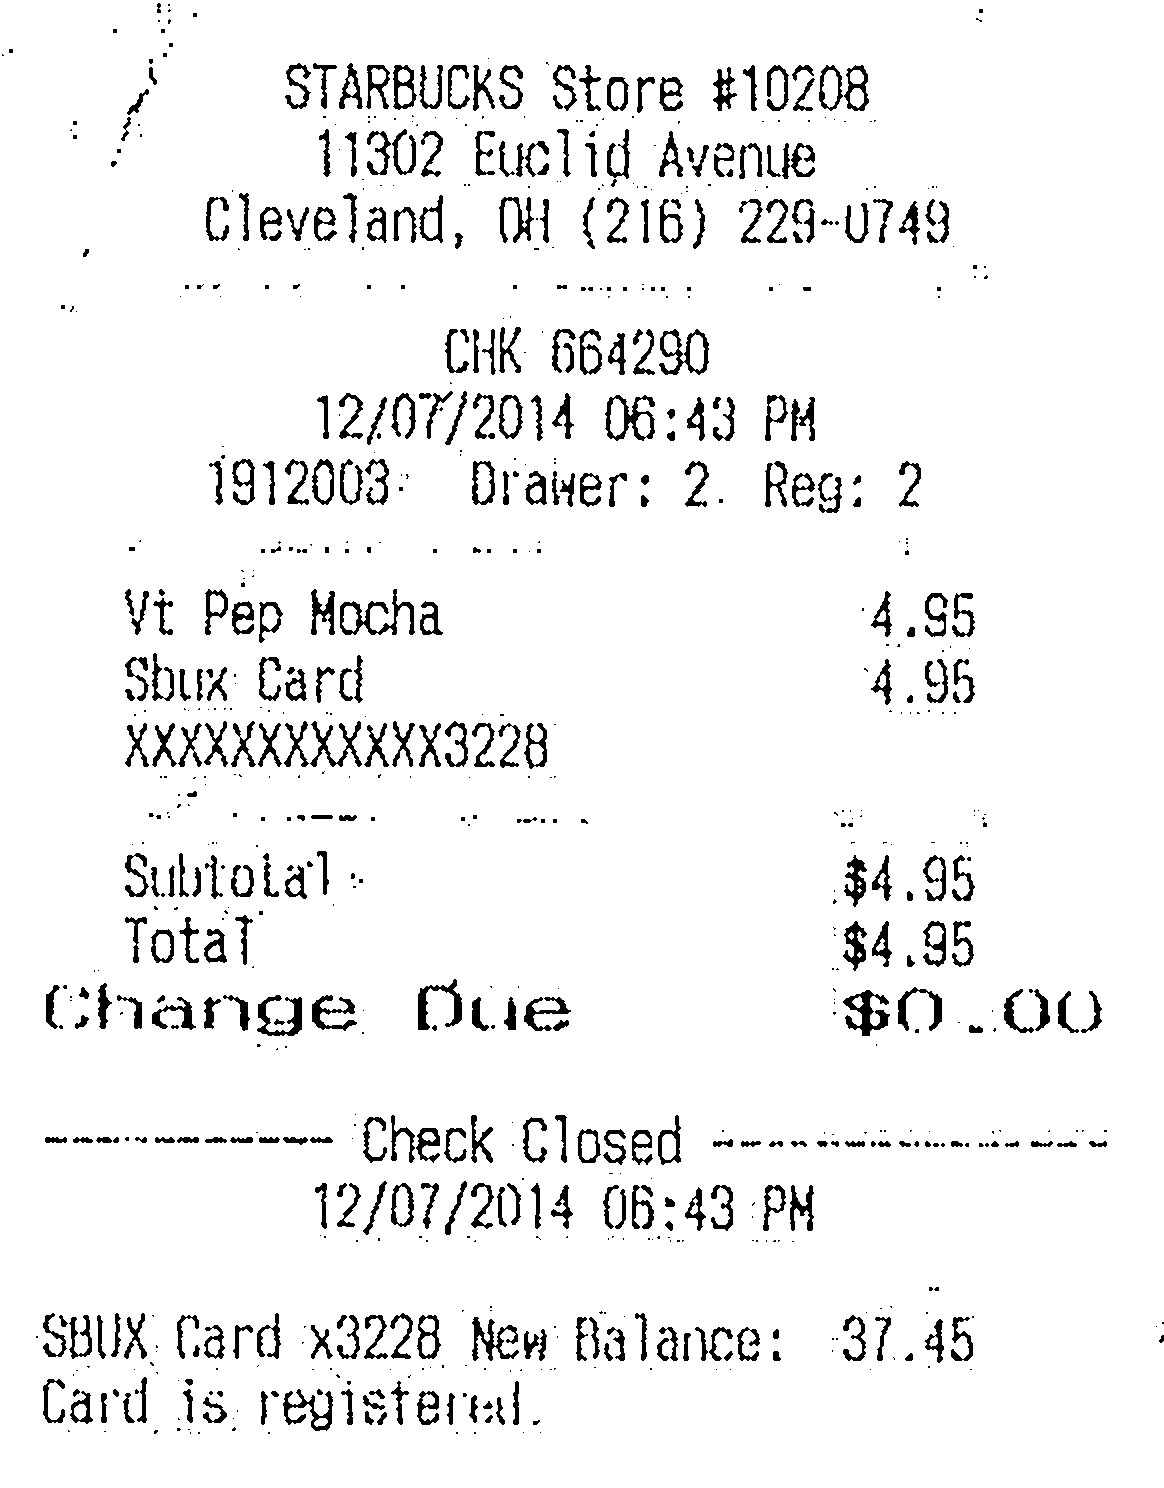

In [310]:
opening_image = ImageMorphologyOperation() \
.setKernelShape(KernelShape.SQUARE) \
.setKernelSize(1) \
.setOperation("erosion") \
.setInputCol("closing_image") \
.setOutputCol("opening_image") \
.transform(closing_image)

display_image(opening_image.select("opening_image").collect()[0].opening_image)

## Remove objects

Image:
        origin: file:/Users/nmelnik/Downloads/check.jpg 
        width: 1164
        height: 1488
        mode: 10


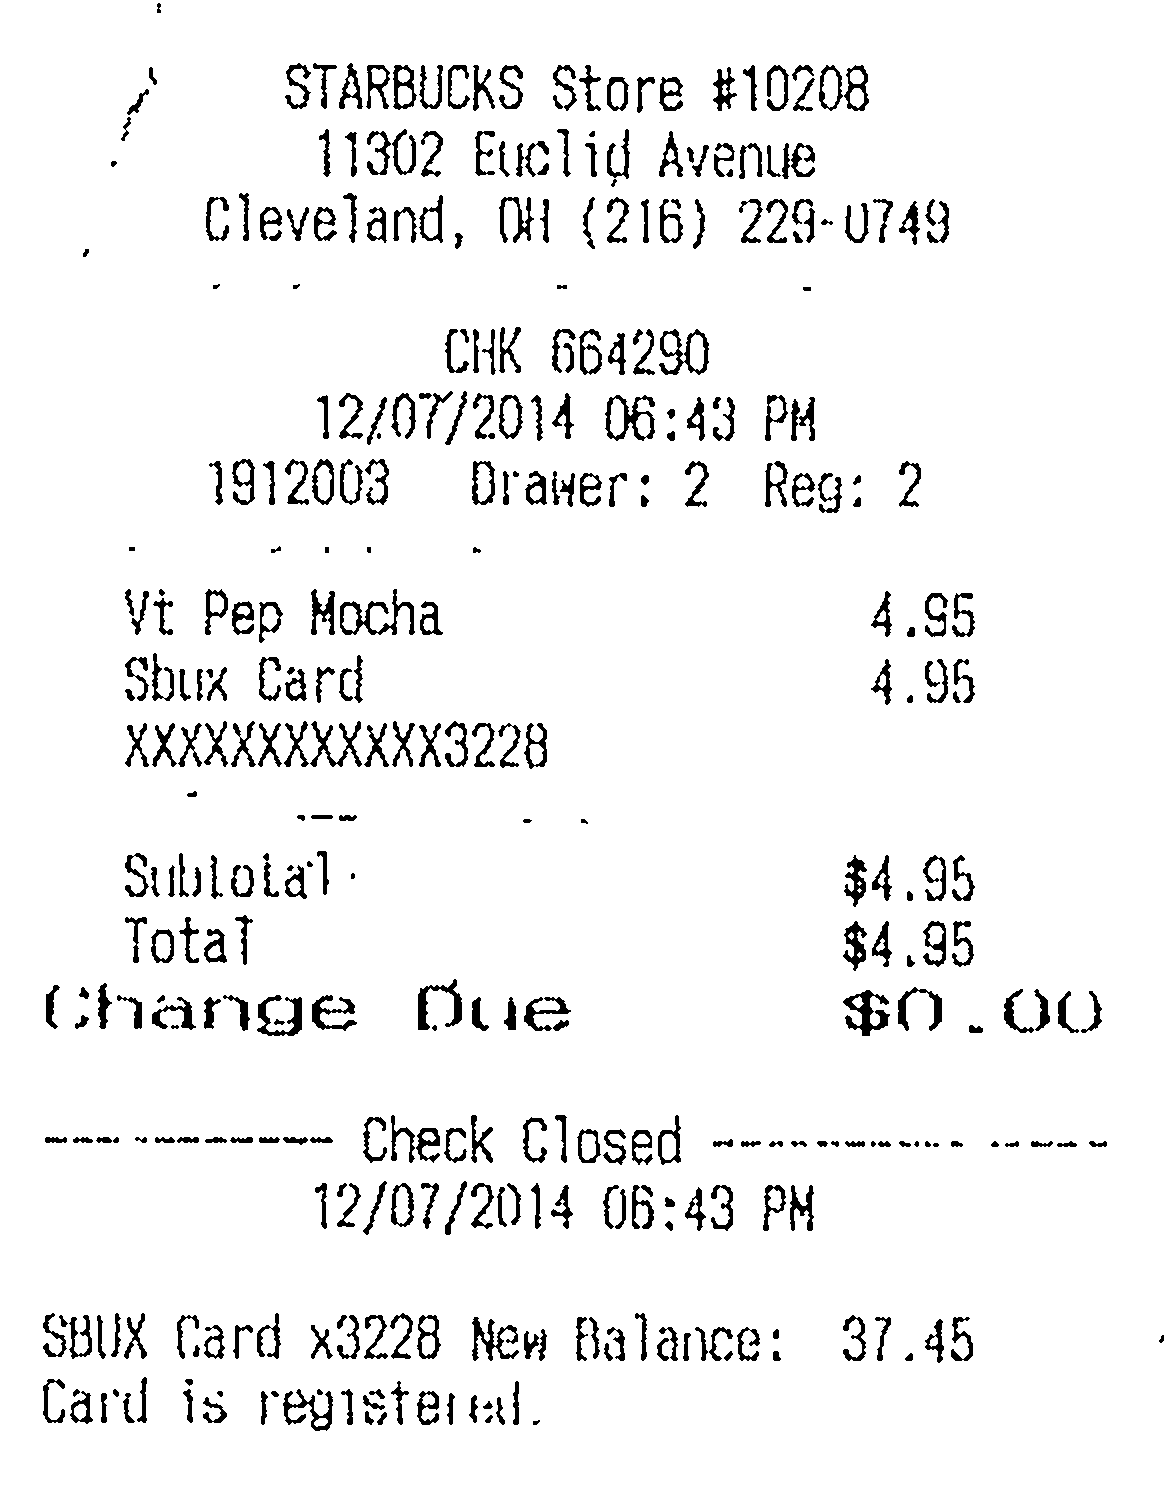

In [313]:
corrected_image = ImageRemoveObjects() \
.setInputCol("opening_image") \
.setOutputCol("corrected_image") \
.setMinSizeObject(20) \
.transform(opening_image)

display_image(corrected_image.select("corrected_image").collect()[0].corrected_image)

## OCR

In [314]:
result = ImageToText() \
.setInputCol("corrected_image") \
.setOutputCol("text") \
.setConfidenceThreshold(40) \
.transform(corrected_image)


print("\n".join([row.text for row in result.select("text").collect()]))

r STARBUCKS Store #10208
; 11902 Euclid Avenue
Cleveland, OH (216) 225-u749

CHK 864290
12/07/2014 06:43 PH
12008 brawer: 2 Reg: 2

VE Pep Mocha 4,5

Sbux Card 4.95

AXXXAXRAXKAKS 228

Sublotal - $4.95

Total $4.95
Change Due BO .00

wowvnmanmnm Check Closed ----v----+ -+-~
12/07/2014 06:43 PM

SBUX Card x3228 New Balance: 37.45
Card is registered.

